<h1 style="text-align:center">Build Non-Linear Models Part 1</h1>
<h2 style="text-align:center">Kaggle Submission 1</h2>
<p style="text-align:center">Robert Evans</p>
<p style="text-align:center">School of Technology & Engineering, National University</p>
<p style="text-align:center">DDS-8555: Predictive Analysis</p>
<p style="text-align:center">Dr. Mohammad Yavarimanesh</p>
<p style="text-align:center">January 26, 2025</p>

## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


## Load Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

## Preprocess Data

In [3]:
# Drop the id column as it's not useful for modeling
train = train.drop(columns=['id'])
X_test = test.drop(columns=['id'])

In [4]:
# Separate features and target variable
X = train.drop(columns=['Rings'])
y = train['Rings']

In [5]:
# Preprocess categorical and numerical columns manually
categorical_features = ['Sex']
numerical_features = X.select_dtypes(include=['float64']).columns.tolist()

In [6]:
# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X[categorical_features])
X_test_categorical_encoded = encoder.fit_transform(X_test[categorical_features])

In [7]:
# Standardize numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X[numerical_features])
X_test_numerical_scaled = scaler.fit_transform(X_test[numerical_features])

In [8]:
# Combine preprocessed features
X_preprocessed = np.hstack((X_numerical_scaled, X_categorical_encoded))
X_test_preprocessed = np.hstack((X_test_numerical_scaled, X_test_categorical_encoded))

In [9]:
X_test_preprocessed

array([[ 1.08472313,  0.74935358,  0.50423579, ...,  0.57288709,
         0.        ,  1.        ],
       [ 0.53203837,  0.59545832,  0.63521348, ...,  0.37646943,
         0.        ,  1.        ],
       [ 0.36198152,  0.18507096,  0.11130274, ...,  0.1107279 ,
         0.        ,  1.        ],
       ...,
       [ 0.6170668 ,  0.39026464,  0.50423579, ...,  0.2994429 ,
         1.        ,  0.        ],
       [ 1.21226577,  1.26233779,  1.42107959, ...,  1.60889394,
         0.        ,  0.        ],
       [-0.74338801, -0.63570377, -0.412608  , ..., -1.04467008,
         0.        ,  0.        ]])

## Split Data into training and testing sets

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [11]:
y_train_log = np.log1p(y_train)

## Train the Model

In [12]:
# Lasso Regression Model
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

LassoCV(cv=5, random_state=42)

## Make Predictions

In [18]:
# Make predictions and evaluate performance
y_pred_log = lasso.predict(X_test)
y_pred_lasso = np.expm1(y_pred_log)
y_test_pred_log = lasso.predict(X_test_preprocessed)
y_test_pred_lasso = np.expm1(y_test_pred_log)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

In [14]:
print("Lasso Regression Results:")
print(f"Mean Squared Error: {lasso_mse}")
print(f"R^2 Score: {lasso_r2}")
print(f"Selected Alpha: {lasso.alpha_}")
print()

Lasso Regression Results:
Mean Squared Error: 4.323842699891383
R^2 Score: 0.5790797440870326
Selected Alpha: 0.00021000566293237144



## Visualizations

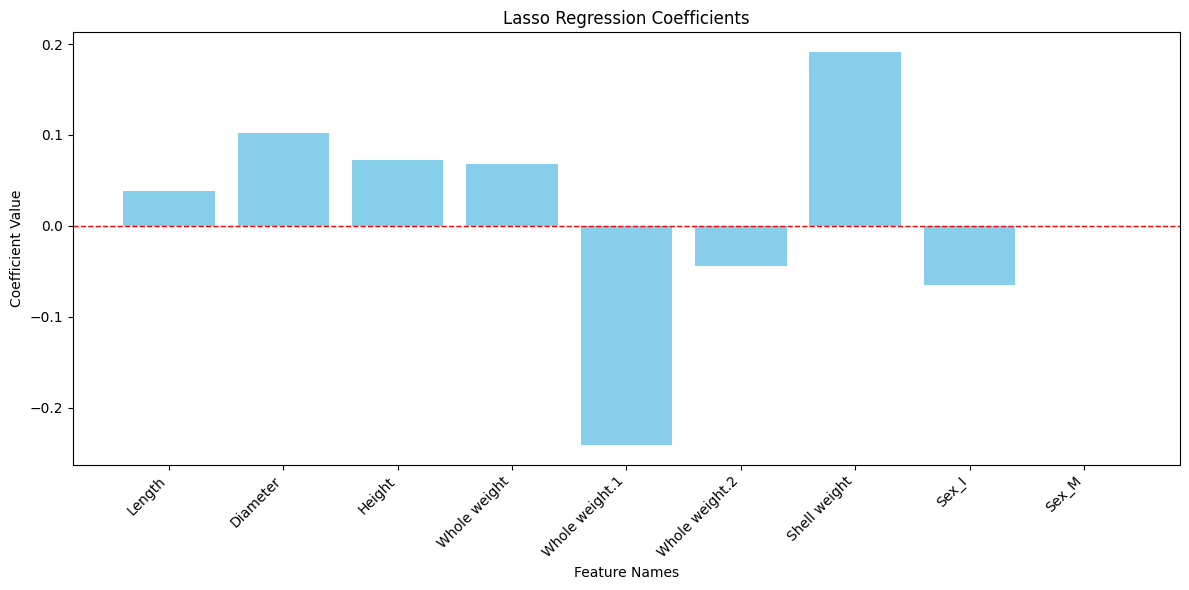

In [15]:
# Get the feature names
numerical_feature_names = numerical_features
categorical_feature_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = numerical_feature_names + list(categorical_feature_names)

# Plot Lasso Coefficients with Feature Names
lasso_coefficients = lasso.coef_

plt.figure(figsize=(12, 6))
plt.bar(all_feature_names, lasso_coefficients, color='skyblue')
plt.title("Lasso Regression Coefficients")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()
plt.show()

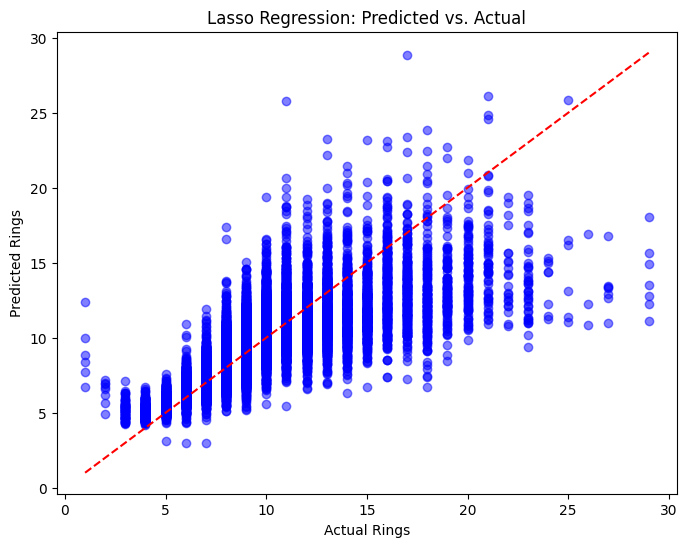

In [16]:
# Predicted vs. Actual Values Visualization for Lasso
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='blue')
plt.title("Lasso Regression: Predicted vs. Actual")
plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Submission

In [19]:
submission = pd.DataFrame({'id':test['id'], 'Rings':y_test_pred_lasso})

In [20]:
submission.describe()

,id,Rings
count,60411.000000,60411.000000
mean,120820.000000,9.545623
std,17439.297893,2.470656
min,90615.000000,2.911732
25%,105717.500000,7.799686
50%,120820.000000,9.531008
75%,135922.500000,10.909964
max,151025.000000,58.907419


In [21]:
submission.to_csv('submission.csv', index=False)